# 0. Install Dependencies and Bring in Data

In [1]:
#!pip install tensorflow pandas matplotlib solution scikit-learn
#tensorflow-gpu
#sklearn

In [2]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [3]:
np.expand_dims??

In [4]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification','train.csv', 'train.csv'))

In [5]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# 1. Preprocess

In [6]:
!pip list

Package                       Version
----------------------------- ---------------
absl-py                       2.0.0
aiobotocore                   2.4.2
aiofiles                      22.1.0
aiohttp                       3.8.3
aioitertools                  0.7.1
aiosignal                     1.2.0
aiosqlite                     0.18.0
alabaster                     0.7.12
altair                        5.1.2
anaconda-anon-usage           0.4.0
anaconda-catalogs             0.2.0
anaconda-client               1.12.0
anaconda-navigator            2.4.3
anaconda-project              0.11.1
annotated-types               0.6.0
anyio                         3.7.1
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
async-timeout                 4.0.2
atomicwrit

In [7]:
from tensorflow.keras.layers import TextVectorization

In [8]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [9]:
MAX_FEATURES = 200000 # number of words in the vocab

In [10]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [11]:
vectorizer.adapt(X.values)

In [12]:
vectorized_text = vectorizer(X.values)

In [13]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [14]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [16]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [17]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [19]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 [==============================] - 4634s 663ms/step - loss: 0.0619 - val_loss: 0.0483


In [20]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

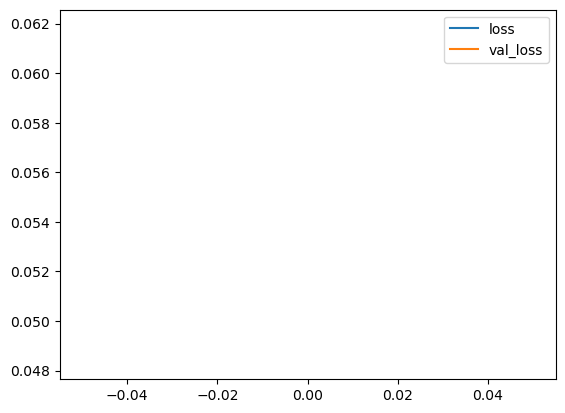

In [21]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [22]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [23]:
res = model.predict(input_text)

ValueError: in user code:

    File "C:\Users\RAJIV\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2416, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\RAJIV\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2401, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\RAJIV\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2389, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\RAJIV\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2357, in predict_step
        return self(x, training=False)
    File "C:\Users\RAJIV\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\RAJIV\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    Input 0 of layer "bidirectional" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 32)
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=int64)
      • training=False
      • mask=None


In [24]:
import numpy as np
input_text = vectorizer('You freaking suck! I am going to hit you.')
input_text = np.expand_dims(input_text, axis=0)
res = model.predict(input_text)

1/1 [==============================] - 1s 746ms/step


In [25]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [26]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [27]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 159ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [28]:
res.shape

(1, 6)

# 4. Evaluate Model

In [29]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [30]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [31]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 99ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 113ms/step


1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 99ms/step


1/1 [==============================] - 0s 99ms/step


In [32]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.7711111307144165, Recall:0.706309974193573, Accuracy:0.49047142267227173


# 5. Test and Gradio

In [39]:
%pip install jinja2

Note: you may need to restart the kernel to use updated packages.


In [43]:
pip install gradio transformers

Note: you may need to restart the kernel to use updated packages.


In [46]:
!pip install transformers

In [47]:
import tensorflow as tf
import gradio as gr
from transformers import pipeline

ImportError: cannot import name 'pipeline' from 'transformers' (C:\Users\RAJIV\anaconda3\Lib\site-packages\transformers\__init__.py)

In [49]:
model.save('SwatchBolBachchan.h5')

In [50]:
model = tf.keras.models.load_model('SwatchBolBachchan.h5')

In [51]:
input_str = vectorizer('hey i freaken hate you!')

In [52]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 1s 669ms/step


In [53]:
res

array([[0.75493807, 0.01280195, 0.3089041 , 0.01925438, 0.28493598,
        0.04135476]], dtype=float32)

In [54]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [55]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.Textbox(lines=2, placeholder='Comment to score'),
                         outputs='text')

In [56]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860


OSError: [WinError 225] Operation did not complete successfully because the file contains a virus or potentially unwanted software: 'C:\\Users\\RAJIV\\anaconda3\\Lib\\site-packages\\gradio\\frpc_windows_amd64_v0.2'

1/1 [==============================] - 0s 86ms/step


In [ ]:
interface.launch()
share_url = interface.share()
print(share_url)
